# MODELO 2 - SABENDO GENERO DO FILME

# POR ACABAR !!!!!!!!!!

In [36]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings

#warnings.filterwarnings("ignore")

plt.rcParams.update({
    "text.usetex": True,              # If you want to use LaTeX fonts in text
    "font.family": "serif",           # IEEE uses Times New Roman-like fonts
    "font.size": 12,                   # General font size for IEEE format
    "axes.labelsize": 12,              # Axis labels font size
    "legend.fontsize": 11,             # Legend font size
    "xtick.labelsize": 11,             # X-axis tick labels font size
    "ytick.labelsize": 11,             # Y-axis tick labels font size
    "figure.figsize": (5, 5*0.8),
    "savefig.dpi": 300,               # DPI for high-quality PNG/JPEG
})

# Load the data

In [37]:
df_train = pd.read_csv("data/data_train.csv")
df_test = pd.read_csv("data/data_test.csv")

In [38]:
with open("data/data_ids.json") as f:
    ids = json.load(f)

max_movieId = max(ids["moviesIDs"].values())
max_userId = max(ids["userIDs"].values())

# Create a matrix of users and movies
base_matrix = np.zeros((max_movieId + 1, max_userId + 1))
base_matrix.shape

(9724, 610)

In [39]:
df_genre = pd.read_csv("data/movies.csv")

# Define functions

In [40]:
# Utility matrix and Binary matrix
from scipy.sparse import lil_matrix

def utility_matrix_AND_binary_matrix(dfTrain, zerosMatrix = base_matrix, jsonIds = ids):
    Y = lil_matrix(zerosMatrix.shape)  # Use sparse matrix format
    R = lil_matrix(zerosMatrix.shape)
    for i, row in dfTrain.iterrows():
        original_movieId, original_userId = int(row["movieId"]), int(row["userId"])
        movieId = jsonIds["moviesIDs"][str(original_movieId)]
        userId = jsonIds["userIDs"][str(original_userId)]
        Y[movieId, userId] = row["rating"]
        R[movieId, userId] = 1
    return Y, R

In [41]:
def cofiCostFunc_Xknown(params, X, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering
    Lambda - regularization parameter
    """
        
    # Unfold the params
    Theta = params
    
    predictions =  X @ Theta.T
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)
    
    #compute regularized cost function
    reg_Theta = Lambda/2 *np.sum(Theta**2)
    reg_J = J + reg_Theta
    
    # Compute gradient
    Theta_grad = (err*R).T @ X
    grad = Theta_grad
    
    # Compute regularized gradient
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = reg_Theta_grad
    
    return J, grad, reg_J, reg_grad

In [42]:
def gradientDescent_Xknown(initial_parameters,X,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
    alpha - learning rate
    Optimize X and Theta
    """
    # unfold the initial parameters (consult function cofiCostFunc)
    Theta = initial_parameters
    
    J_history =[]
    
    for i in range(num_iters):
        #Append into a single vector params X and Theta (see above)
        params = Theta
        cost, Theta_grad = cofiCostFunc_Xknown(params, X, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        #Update trainable parameters X & Theta applying gradient descent method        
        Theta = Theta - alpha*Theta_grad
        
        J_history.append(cost)
    
    #Append into a single vector paramsFinal the updated X and Theta
    paramsFinal = Theta
    return paramsFinal , J_history

# Set model features: X (movies genres as features)

In [43]:
num_movies, num_users = base_matrix.shape

genres = df_genre["genres"].str.split("|").tolist()
genres = {genre: 0 for sublist in genres for genre in sublist}
# create X: movies features
X = np.zeros((num_movies, len(genres))) # 20 genres
for movie in ids["moviesIDs"]:
    movieId_matrix = ids["moviesIDs"][movie]
    genre_dict = genres.copy()
    genres_list = df_genre[df_genre["movieId"] == int(movie)]["genres"].str.split("|").tolist()[0]
    for genre in genres_list:
        genre_dict[genre] = 1 / len(genres_list)
    X[movieId_matrix] = list(genre_dict.values())

X.shape

(9724, 20)

# Start modelling

In [44]:
# Shuffle the DataFrame randomly and split it into 8 parts
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

# define the number of movies, users and features
num_movies, num_users = base_matrix.shape
num_features = 20

/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [45]:
results_stored = {(0, 0.005): 0.9840711598039373,
 (0, 0.0005): 1.2788811778538607,
 (0, 0.001): 1.1127864772566063,
 (0, 0.0075): 5.601493940739115e+105,
 (5, 0.005): 1.5331568622653198,
 (5, 0.0005): 1.5859375620130582,
 (5, 0.001): 1.5396687638664905,
 (5, 0.0075): 4.364430499943079e+110,
 (10, 0.005): 1.8280749714092337,
 (10, 0.0005): 1.8380954108504541,
 (0, 0.0055): 0.9821569988696647,
 (5, 0.0055): 1.533156849580742,
 (10, 0.001): 1.8283913279304576,
 (1, 0.005): 1.1074223075018303,
 (3, 0.005): 1.355656539850337,
 (2, 0.005): 1.2427074684501644,
 (15, 0.005): 2.0214945932880273,
 (20, 0.005): 2.164069908617318,
 (0.1, 0.005): 0.989987655349287,
 (0.5, 0.005): 1.0351197733959776,
 (0, 0.002): 1.026453785975172,
 (0.1, 0.0005): 1.2836611866909944,
 (0.1, 0.001): 1.1189147974518,
 (0.1, 0.0055): 0.9876443635034207,
 (0.1, 0.002): 1.0331659544104292,
 (0.2, 0.005): 0.9986996157952619,
 (0.2, 0.0005): 1.2900517525794473,
 (0.2, 0.001): 1.1269235771152766,
 (0.2, 0.0055): 0.9960532840094553,
 (0.2, 0.002): 1.041783329785714,
 (1, 0.0005): 1.337174235983246,
 (1, 0.001): 1.1949946765986441,
 (1, 0.0055): 1.1069031715136974,
 (1, 0.002): 1.1293868381677885,
 (0.5, 0.0005): 1.3069111025875428,
 (0.5, 0.001): 1.1508983488512108,
 (0.5, 0.0055): 1.0336107573164997,
 (0.5, 0.002): 1.0711857501235909,
 (2, 0.0005): 1.4004237022020671,
 (2, 0.001): 1.2882144775452624,
 (2, 0.0055): 1.2426694222528734,
 (2, 0.002): 1.2493780409219197,
 (0.05, 0.005): 0.9861742442921604,
 (0.05, 0.0005): 1.2814398284137614,
 (0.05, 0.001): 1.1156459064276887,
 (0.05, 0.0055): 0.984353096458239,
 (0.05, 0.002): 1.0292129526552873}

In [46]:
Lambdas = [0, 0.1,0.2,1, 0.5, 2,0.05]
alphas = [0.005, 0.0005, 0.001, 0.0055, 0.002]
num_iters = 500

combo = 1
results = {}
for Lambda in Lambdas:
    for alpha in alphas:
        if (Lambda, alpha) in results_stored:
            print(f"Combination {combo} of {len(Lambdas)*len(alphas)} with ({Lambda}, {alpha}):") 
            combo += 1
            continue
        
        print(f"Combination {combo} of {len(Lambdas)*len(alphas)} with ({Lambda}, {alpha}):", end=" ") 
        combo += 1

        avg_RMSE = 0
        for exclude_index in range(8):
            merged_df = pd.concat([part for i, part in enumerate(folds) if i != exclude_index])

            # Create the utility matrix and the binary matrix
            Y, R = utility_matrix_AND_binary_matrix(merged_df)
            Y, R = Y.toarray(), R.toarray()

            # Define the initial parameters
            X = X
            Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
            initial_parameters = Theta

            # Apply gradient descent
            param, jhist = gradientDescent_Xknown(initial_parameters,X,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda)

            # Unfold the final parameters
            X = X
            Theta = param

            # Predict all ratings of num_users for num_movies
            p = X @ Theta.T

            # Compute the RMSE
            RMSE = 0
            for i, row in folds[exclude_index].iterrows():
                movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
                userId_matrix = ids["userIDs"][str(int(row["userId"]))]
                RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
            RMSE = np.sqrt(RMSE/len(folds[exclude_index]))
            print(f"CV{exclude_index+1}: {RMSE:.1f}", end=", ")
            avg_RMSE += RMSE/8
        
        results[(Lambda, alpha)] = avg_RMSE
        print("")

Combination 1 of 35 with (0, 0.005):
Combination 2 of 35 with (0, 0.0005):
Combination 3 of 35 with (0, 0.001):
Combination 4 of 35 with (0, 0.0055):
Combination 5 of 35 with (0, 0.002):
Combination 6 of 35 with (0.1, 0.005):
Combination 7 of 35 with (0.1, 0.0005):
Combination 8 of 35 with (0.1, 0.001):
Combination 9 of 35 with (0.1, 0.0055):
Combination 10 of 35 with (0.1, 0.002):
Combination 11 of 35 with (0.2, 0.005):
Combination 12 of 35 with (0.2, 0.0005):
Combination 13 of 35 with (0.2, 0.001):
Combination 14 of 35 with (0.2, 0.0055):
Combination 15 of 35 with (0.2, 0.002):
Combination 16 of 35 with (1, 0.005):
Combination 17 of 35 with (1, 0.0005):
Combination 18 of 35 with (1, 0.001):
Combination 19 of 35 with (1, 0.0055):
Combination 20 of 35 with (1, 0.002):
Combination 21 of 35 with (0.5, 0.005):
Combination 22 of 35 with (0.5, 0.0005):
Combination 23 of 35 with (0.5, 0.001):
Combination 24 of 35 with (0.5, 0.0055):
Combination 25 of 35 with (0.5, 0.002):
Combination 26 of 3

In [47]:
results

{}

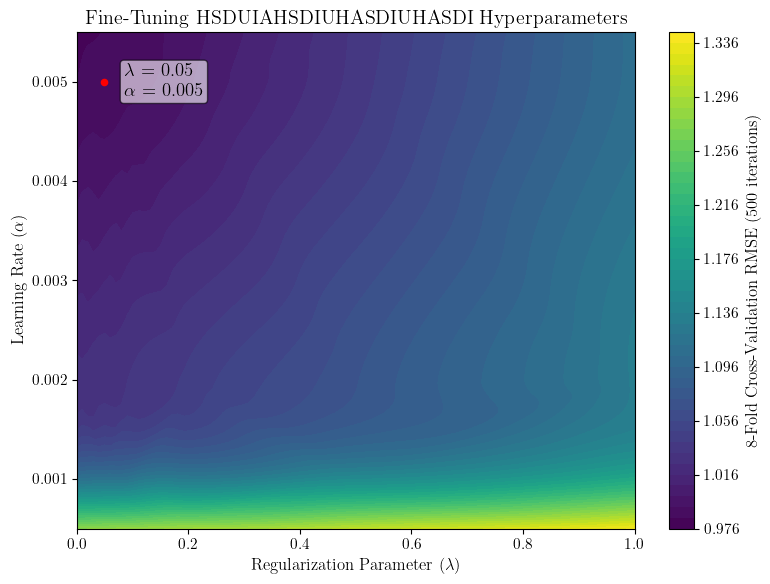

In [48]:
from scipy.interpolate import griddata

results = {x:y for x,y in results_stored.items() if x[1] < 0.007 and x[0] <2}
# Extract x, y, and z values
points = np.array(list(results.keys()))
x, y = points[:, 0], points[:, 1]
z = np.array(list(results.values()))

# Create a grid for interpolation
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100) #max()
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values onto the grid
zi = griddata(points, z, (xi, yi), method='cubic') #nearest, cubic, linear

# Plot the topographic map
plt.figure(figsize=(8, 6))
contour = plt.contourf(xi, yi, zi, levels=50, cmap='viridis')
plt.colorbar(contour, label='8-Fold Cross-Validation RMSE (500 iterations)')
best_lambda, best_alpha = (0.05, 0.005)
plt.scatter(best_lambda, best_alpha, color='red', s=20)
plt.text(
    best_lambda * 1.7, 
    best_alpha, 
    r"$\lambda$ = " + f"{best_lambda}\n" + r"$\alpha$ = " + str(best_alpha), 
    fontsize=13.5, 
    color='black',
    va = 'center',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
)
plt.title('Fine-Tuning HSDUIAHSDIUHASDIUHASDI Hyperparameters')
plt.xlabel(r'Regularization Parameter ($\lambda$)')
plt.ylabel(r'Learning Rate ($\alpha$)')
plt.tight_layout()
#plt.savefig('images/model02_hyperparemeterstunning.png')
plt.show()

In [49]:
# choose the best hyperparameters
best_lambda, best_alpha = (0.05, 0.005)
print(f"The best hyperparameters are: ({best_lambda}, {best_alpha}) with RMSE: {results_stored[(best_lambda, best_alpha)]:.5f}")

The best hyperparameters are: (0.05, 0.005) with RMSE: 0.98617


# Evaluate the optimized model

In [50]:
# Create the utility matrix and the binary matrix
Y, R = utility_matrix_AND_binary_matrix(df_train)
Y, R = Y.toarray(), R.toarray()

# Define the initial parameters
Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
initial_parameters = Theta

# Apply gradient descent
param, jhist = gradientDescent_Xknown(initial_parameters,X,Y,R,num_users,num_movies,num_features,best_alpha,750,best_lambda)

# Unfold the final parameters
X = X
Theta = param

# Predict all ratings of num_users for num_movies
p = X @ Theta.T

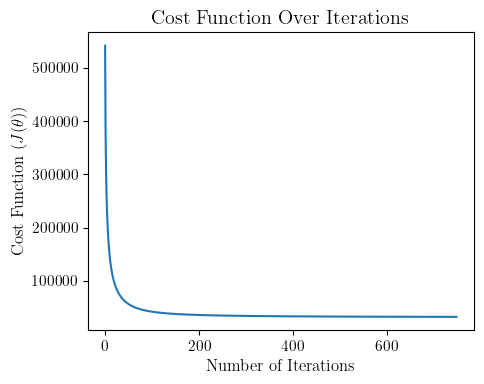

In [51]:
plt.plot(jhist)
plt.title("Cost Function Over Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel(r"Cost Function ($J(\theta)$)")
plt.tight_layout()
plt.savefig("assets/model02_cost_function.png")
plt.show()

In [52]:
df_to_evaluate = df_train
RMSE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
RMSE = np.sqrt(RMSE/len(df_to_evaluate))
print(f"RMSE for train set: {RMSE:.5f}")

df_to_evaluate = df_test
RMSE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
RMSE = np.sqrt(RMSE/len(df_to_evaluate))
print(f"RMSE for test set: {RMSE:.5f}")

RMSE for train set: 0.84865
RMSE for test set: 0.97232


In [53]:
df_to_evaluate = df_train
MAE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    MAE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])
MAE = MAE/len(df_to_evaluate)
print(f"MAE for train set: {MAE:.5f}")

df_to_evaluate = df_test
MAE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    MAE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])
MAE = MAE/len(df_to_evaluate)
print(f"MAE for train set: {MAE:.5f}")

MAE for train set: 0.66006
MAE for train set: 0.74606


In [54]:
# Create the utility matrix and the binary matrix
Y, R = utility_matrix_AND_binary_matrix(df_train)
Y, R = Y.toarray(), R.toarray()


# Shuffle the DataFrame randomly and split it into 8 parts
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

dict_RMSE = {}
for fold in range(8):
    merged_df = pd.concat([part for i, part in enumerate(folds) if i != fold])

    # Define the initial parameters
    X = X
    Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
    params = Theta
    for train_set_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

        merged_df_sized = merged_df.sample(frac=train_set_size, random_state=42)

        Y, R = utility_matrix_AND_binary_matrix(merged_df_sized)
        Y, R = Y.toarray(), R.toarray()

        
    
        # Apply gradient descent
        param, jhist = gradientDescent_Xknown(params,X,Y,R,num_users,num_movies,num_features,best_alpha,750,best_lambda)

        # Unfold the final parameters
        X = X
        Theta = param

        # Predict all ratings of num_users for num_movies
        p = X @ Theta.T

        df_to_evaluate = folds[fold]
        RMSE = 0
        for i, row in df_to_evaluate.iterrows():
            movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
            userId_matrix = ids["userIDs"][str(int(row["userId"]))]
            RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
        RMSE = np.sqrt(RMSE/len(df_to_evaluate))
        dict_RMSE[(fold, train_set_size, "test")] = RMSE

        df_to_evaluate = merged_df
        RMSE = 0
        for i, row in df_to_evaluate.iterrows():
            movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
            userId_matrix = ids["userIDs"][str(int(row["userId"]))]
            RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
        RMSE = np.sqrt(RMSE/len(df_to_evaluate))
        dict_RMSE[(fold, train_set_size, "train")] = RMSE

        print(f"Fold {fold+1} with {train_set_size} in train_set_size: done")

/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Fold 1 with 0.1 in train_set_size: done


KeyboardInterrupt: 

In [56]:
# por acabar learning curve

# por salvar modelo